# Information retrieval --- Module 1: Evaulation
Santhosh Kumar Rajamanickam, Dennis Ulmer and Stian Steinbakken

TODO: Maybe insert a small introduction here? 


## Theoretical part [15pts]
### 1 Hypothesis Testing --- The problem of multiple comparisons. 
How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):
1. P(mth experiment gives significant result | m experiments lacking power to reject H0)?
2. P(at least one significant result | m experiments lacking power to reject H0)?



**Answer**

1. Because the outcome of the experiments are independent, we can just multiply the probabilities of the outcomes in this question. The probability of an experiment giving a significant result, i.e. rejecting the Null Hypothesis, will be $\alpha$. Likewise, the probability of experiments lacking the power to reject $H_0$ will be $1-\alpha$. Therefore

\begin{equation}
P(m^{th}\text{ experiment gives significant result } | \ m\text{ experiments lacking power to reject } H_0) = (1-\alpha)^{m-1}\alpha
\end{equation}

2. The probability of at least one in $m$ experiments rejecting the Null Hypothesis falsely is the sum of the probabilities of a experiment at time step $t$ rejecting the Null-Hypothesis conditioned on the previous experiments rejecting it correctly:

\begin{equation}
   p(\text{rejecting the Null Hypothesis at least once}|m\text{ experiments lacking power to reject }H_0)\\ = p(1^{st}\text{ wrong}) + p(2^{nd} \text{wrong}\ |\ 1^{st}\ \text{right}) + \ldots + p(m^{th} \text{wrong}\ |\ \text{all}\ m-1\ \text{experiments}\ \text{right})\\
   = \alpha + (\alpha - 1)\alpha + (\alpha-1)^2\alpha + \ldots + (\alpha-1)^{m-1}\alpha\\
   = \alpha \cdot {\displaystyle \sum_{t=0}^{m-1}} (\alpha-1)^t
\end{equation}

### 2 Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?


**Answer**

Assume we have to algorithms A and B providing documents for an interleaved ranking of length $3$, where A is the worse algorithm. While constructing the interleaved ranking, the result of two coin tosses where A wins gives A preference to place its documents first. Because we only have three entries, two of the entries will originate from A and only one from B.

Given random clicking, A will again win ⅔ of times. Here the unfairness is due to the coin tosses.

## Experimental part [85 pts] 
Step 1: Simulate Rankings of Relevance for E and P (5 points)
In the first step you will generate pairs of rankings of relevance, for the production P and experimental E, respectively, for a hypothetical query q. Assume a 3-graded relevance, i.e. {N, R, HR}. Construct all possible P and E ranking pairs of length 5. This step should give you about.

Example:
P: {N N N N N}
E: {N N N N R}
…
P: {HR HR HR HR R}
E: {HR HR HR HR HR}


In [19]:
# Step 1 code

from itertools import product
from collections import namedtuple

RankingPair = namedtuple("RankingPair", ["E", "P"])

RANKINGS = ("N", "R", "HR")

simulations = []

# Create all possible rankings of length 5
for ranking_pair in list(product(list(product(RANKINGS, repeat=5)), repeat=2)):
    simulations.append(RankingPair(*ranking_pair))

print("{} simulations in total.\n".format(len(simulations)))
    
print("First 10 simulations:\n")
for ranking_pair in simulations[:10]:
    print("P: {}, E: {}".format(*ranking_pair))
    
print("\nLast 10 simulations:\n")
for ranking_pair in simulations[-10:]:
    print("P: {}, E: {}".format(*ranking_pair))


59049 simulations in total.

First 10 simulations:

P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'N', 'N')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'N', 'R')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'N', 'HR')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'R', 'N')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'R', 'R')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'R', 'HR')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'HR', 'N')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'HR', 'R')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'N', 'HR', 'HR')
P: ('N', 'N', 'N', 'N', 'N'), E: ('N', 'N', 'R', 'N', 'N')

Last 10 simulations:

P: ('HR', 'HR', 'HR', 'HR', 'HR'), E: ('HR', 'HR', 'R', 'HR', 'HR')
P: ('HR', 'HR', 'HR', 'HR', 'HR'), E: ('HR', 'HR', 'HR', 'N', 'N')
P: ('HR', 'HR', 'HR', 'HR', 'HR'), E: ('HR', 'HR', 'HR', 'N', 'R')
P: ('HR', 'HR', 'HR', 'HR', 'HR'), E: ('HR', 'HR', 'HR', 'N', 'HR')
P: ('HR', 'HR', 'HR', 'HR', 'HR'), E: ('HR', 'HR', 'HR', 'R

### Step 2: Implement Evaluation Measures (10 points)
Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 


In [20]:
# Implementation of Average Precision (AP)

def precision(rankings):
    relevant_tags = (RANKINGS[1], RANKINGS[2]) # 'R' and 'HR'
    
    relevant_rankings = sum([1 for rank in rankings if rank in relevant_tags])
    return relevant_rankings / len(rankings) 

# For our binary evaulation meassure we implement average precision (AP)
def average_precision(rankings, num_relevant=None):
    if num_relevant == None:
        num_relevant = len(rankings)
    relevant_tags = (RANKINGS[1], RANKINGS[2]) # 'R' and 'HR'
    return sum([precision(rankings[:i+1]) for i in range(len(rankings)) if rankings[i] in relevant_tags]) / num_relevant

def test_average_precision():
    example_rank_1 = ('R', 'R', 'R', 'R', 'R')
    example_rank_2 = ('N', 'N', 'N', 'N', 'N')
    example_rank_3 = ('N', 'R', 'N', 'N', 'R')
    """
    Example rank 3 should yield (1/2 + 2/5) / 5 = (0.5 + 0.4) / 5 = 0.18
    """
    
    assert average_precision(example_rank_1) == 1
    assert average_precision(example_rank_2) == 0
    assert average_precision(example_rank_3) == 0.18
    return True

AP_passed = test_average_precision()
if AP_passed: print("All average-precision tests passed")


All average-precision tests passed


In [21]:
# Implementation of Normalized Discounted Cumulative Gain at rank k (nDCG@k)
import math
from functools import cmp_to_key

# Assumptation
RANKING_WEIGHTS = {"N": 0, "R": 1, "HR": 5}

def sort_ranks(ranks):
    """ Sort ranks by relevance, assuming HR > R > N. """
    def sort_func(rank1, rank2):
        if rank1 == rank2:
            return 0
        elif rank1 == "HR":
            return 1
        elif rank2 == "HR":
            return -1
        elif rank1 == "R":
            return 1
        elif rank2 == "R":
            return -1
        else:
            return -1
        
    return sorted(ranks, key=cmp_to_key(sort_func), reverse=True)

def ndcg(ranks, gain=lambda rank: 2**RANKING_WEIGHTS[rank]-1, k=5):
    # Calculate dcg, but normalize by the ideal dcg for this list,
    # which would be the list with their elements sorted in a descending order.
    try:
        return dcg(ranks, gain, k) / dcg(sort_ranks(ranks), gain, k)
    except ZeroDivisionError:
        return 0

def dcg(ranks, gain=lambda rank: 2**RANKING_WEIGHTS[rank]-1, k=5):
    return sum([gain(rank) / math.log(2+i, 2) for i, rank in enumerate(ranks[:k])])


In [22]:
# Implementation of Expected Reciprocal Rank (ERR)

def sat_prob_mapping(grade, grade_max=5):
    return ((2**grade)-1)/2**grade_max

def err(rankings):
    return sum([ (1/(i+1))*sat_prob_mapping(RANKING_WEIGHTS[grade]) for i, grade in enumerate(rankings)])
    


### Step 3: Calculate the 𝛥measure (10 points)
For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.


In [23]:
def delta_measure(simulations, measure_to_test):
    # Measure_to_test argument must be a function that takes in a ranking to be measured
    # We do this so that the function can be re-used for each of the measures
    results = []
    
    for sim in simulations:
        E_ranking, P_ranking = sim
        P_measure, E_measure = measure_to_test(P_ranking), measure_to_test(E_ranking)
        
        results.append(E_measure - P_measure if E_measure > P_measure else 0)
    return results
        
delta_m_AP = delta_measure(simulations, average_precision)
delta_m_ndcg = delta_measure(simulations, ndcg)
#print("Delta_m for average_precision:", delta_m_AP)
#print("Delta_m for Normalized Discounted Cumulative Gain:", delta_m_ndcg)

# TODO: Run delta_measure for the remaining measures

### Step 4: Implement Interleaving (15 points)
Implement 2 interleaving algorithms: (1) Team-Draft Interleaving OR Balanced Interleaving, AND (2), Probabilistic Interleaving. The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

(Note 4: Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, in our case the rankings consist of relevance labels. Hence in this case (a) you will assume that E and P return different documents, (b) the interleaved ranking will also be a ranking of labels.)

In [24]:
# Step 4 code
# TODO: Stian (I can do both)
# TODO: Assign credit
from random import choice 

def team_draft_interleaving(rankings_1, rankings_2, interleaved_rankings_size=5):
    interleaved_rankings = []
    i = -1
    
    # TODO: Use all entries in ranking 1 and 2 for interleaving
    while len(interleaved_rankings) < interleaved_rankings_size:
        i += 1
        
        if choice(["H", "T"]) == "H":
            interleaved_rankings.append(rankings_1[i])
            
            if len(interleaved_rankings) < interleaved_rankings_size:
                interleaved_rankings.append(rankings_2[i])
        else:
            interleaved_rankings.append(rankings_2[i])
            
            if len(interleaved_rankings) < interleaved_rankings_size:
                interleaved_rankings.append(rankings_1[i])
            
    return interleaved_rankings

example_rank_1 = ('R', 'R', 'R', 'R', 'R')
example_rank_2 = ('N', 'N', 'N', 'N', 'N')

interleaved = team_draft_interleaving(example_rank_1, example_rank_2)
print(interleaved)
        

['R', 'N', 'R', 'N', 'R']


### Step 5: Implement User Clicks Simulation (15 points)
Having interleaved all the ranking pairs an online experiment could be ran. However, given that we do not have any users (and the entire homework is a big simulation) we will simulate user clicks.

We have considered a number of click models including:
1. Random Click Model (RCM)
2. Position-Based Model (PBM)
3. Simple Dependent Click Model (SDCM)
4. Simple Dynamic Bayesian Network (SDBN)

Consider two different click models, (a) the Random Click Model (RCM), and (b) one out of the remaining 3 aforementioned models. The parameters of some of these models can be estimated using the Maximum Likelihood Estimation (MLE) method, while others require using the Expectation-Maximization (EM) method. Implement the two models so that (a) there is a method that learns the parameters of the model given a set of training data, (b) there is a method that predicts the click probability given a ranked list of relevance labels, (c) there is a method that decides - stochastically - whether a document is clicked based on these probabilities.



In [25]:
import codecs
from collections import defaultdict

class YandexData:
    """ Class to represent the entire dataset. """
    def __init__(self, sessions={}):
        self.page_length = 10  # Number of result on every page
        self.sessions = sessions
        self.docid2sessions = defaultdict(list)  # Return the sessions a specific document is in
        self.queryid2sessions = defaultdict(list)  # Return the sessions a specific query is in
        self.querydocid2rank = defaultdict(int)  # Return the rank of a document in a specific query
        self.querydocid2sessions = defaultdict(list)
        self.sessiondocid2query = defaultdict(int)
        
    def add(self, session):
        self.sessions[session.uid] = session
        
        # Store in which sessions this document occurs
        for document_id in session.documents:
            self.docid2sessions[document_id].append(session.uid)
            
        # Store in which session this query occurs
        for query in session.queries:
            self.queryid2sessions[query.query_id].append(session.uid)
            
            # Store in which session this query and document occurs
            for document_id in query.document_ids:
                self.querydocid2sessions[(query.query_id, document_id)].append(session.uid)
                
                #print("Adding session {} to query {} and doc {}".format(session.uid, query.query_id, document_id))
            
        # TODO: Comment
        for query in session.queries:
            self.sessiondocid2query[(session.uid, document_id)] = query.query_id
            #print("Adding doc #{} for query #{} with rank {}".format(document_id, query.query_id, i + current_page_count * 10 + 1))
            
        
    def __getitem__(self, items):
        return list(self.sessions.values())[items]
        
    def __iter__(self):
        for session in self.sessions.values():
            yield session
    
    def __len__(self):
        return len(self.sessions)
    
    @property
    def queries(self):
        """ Return all queries in the entire data set. """
        for session in self:
            for query in session.queries:
                yield query
                
    @property
    def clicks(self):
        """ Return all clicks in the entire data set. """
        for session in self:
            for click in session.clicks:
                yield click
                
    def __repr__(self):
        return "<YandexData comprising {} sessions>".format(len(self))


class Session:
    def __init__(self, uid, user_actions):
        self.uid = uid
        self.user_actions = user_actions
        self._queries = None
        self._clicks = None
        self._documents = None
        self._clicked = None
        
    def __iter__(self):
        return (user_action for user_action in self.user_actions)
    
    def __contains__(self, element):
        return element in self.documents
    
    def rank_of_document(self, document_id):
        rank = self.documents.index(document_id)
        
        if rank == -1:
            raise IndexError("Document ID #{} not found in session #{}.".format(document_id, self.uid))
        
        return rank
    
    def document_at_rank(self, rank):
        return self.documents[rank]
    
    def has_been_clicked(self, document_id):
        if self._clicked == None:
            clicked = set()
            for click in self.clicks:
                clicked.add(click.document_id)
                
            self._clicked = clicked
            
        return document_id in self._clicked
    
    @property
    def queries(self):
        """ Return all queries in this session. """
        if self._queries == None:
            self._queries = [action for action in self.user_actions if action.action_type == "Q"]
        return self._queries
    
    @property
    def clicks(self):
        """ Return all clicks in this session. """
        if self._clicks == None:
            self._clicks = [action for action in self.user_actions if action.action_type == "C"]
        return self._clicks
    
    @property
    def documents(self):
        """ Return all documents in this session. """
        if self._documents == None:

            document_ids = []

            # TODO: Consider all documents shown or just unique documents?
            for query in self.queries:
                document_ids.extend(query.document_ids)

            self._documents = document_ids
            
        return self._documents
    
    def __repr__(self):
        return "<Session #{}>".format(self.uid)
        

class UserAction:
    def __init__(self, session_id, time_passed, action_type, *document_ids):
        self.session_id = session_id
        self.time_passed = time_passed
        self.action_type = action_type
        self.document_ids = document_ids
        
    def __iter__(self):
        return (document_id for document_id in self.document_ids)
            
    def __contains__(self, document_id):
        return document_id in self.document_ids
        
class Query(UserAction):
    def __init__(self, session_id, time_passed, query_id, region_id, *document_ids):
        self.query_id = query_id
        self.region_id = region_id
        super().__init__(session_id, time_passed, "Q", *document_ids)
        
    def __repr__(self):
        return "<Query #{} in session #{}>".format(self.query_id, self.session_id)
        
        
class Click(UserAction):
    def __init__(self, session_id, time_passed, *document_ids):
        super().__init__(session_id, time_passed, "C", *document_ids)
        self.document_id = document_ids[0]
    
    def __repr__(self):
        return "<Click in session #{} on #{}>".format(self.session_id, self.document_id)
        


def read_yandex_data(path="./YandexRelPredChallenge.txt"):
    """ Parse the data set into an appropriate data structure. """
    data = YandexData()
    current_session_id = 0
    current_actions = []
    
    with codecs.open(path, "rb", "utf-8") as file:
        for line in file.readlines():
            columns = line.strip().split("\t")
            columns = tuple(map(lambda x: int(x) if x not in ("Q", "C") else x, columns))  # Parse numbers
            session_id, time_passed, action_type, *document_ids = columns
            
            # New session, create object, save it and start a new one
            if session_id != current_session_id:
                session = Session(current_session_id, current_actions)
                data.add(session)
                
                current_session_id = session_id
                current_actions = []
            
            if action_type == "Q":
                # Get query id
                query_id, region_id, *document_ids = document_ids
                current_actions.append(Query(session_id, time_passed, query_id, region_id, *document_ids))
            else:
                # It's a click!
                current_actions.append(Click(session_id, time_passed,  *document_ids))
                
    return data
        
yandex_data = read_yandex_data()
print(yandex_data, "\n")

# You can now iterate over sessions in the data set like this:
for session in yandex_data:
    pass  # Do something

# You iterate over slices of the data set:
for session in yandex_data[5:10]:
    print(session)
    
print("")
    
# You can iterate over all the queries in the entire data set:
for query in yandex_data.queries:
    pass  # Do something

# ... or of a single session
for query in yandex_data[0].queries:
    print(query)
    
# (Multiple queries with the same id might be the user clicking trough result pages?)
    
print("")
    
for click in yandex_data[0].clicks:
    print(click)

<YandexData comprising 11716 sessions> 

<Session #5>
<Session #6>
<Session #7>
<Session #8>
<Session #9>

<Query #8 in session #0>
<Query #174 in session #0>
<Query #227 in session #0>
<Query #174 in session #0>
<Query #1974 in session #0>

<Click in session #0 on #17562>
<Click in session #0 on #1627>
<Click in session #0 on #1626>


In [26]:
# Step 5 code
# TODO: Santhosh: implement RCM
# TODO: Dennis: one of the remaining 3

In [27]:
# Has to do do three things
# TODO: method to estimate parameters from training data
# TODO: method that predicts click probability given ranked list
# TODO: method to decide whether a document is clicked or not 

import abc
import random
import matplotlib.pyplot as plt

class ClickModel:
    
    @abc.abstractmethod
    def estimate_parameters(self, data, **params):
        """Estimate the parameters of the model using the training data"""
        pass
    
    @abc.abstractmethod
    def predict_click_prob(self, rankings):
        """Return a list of probabilities of the document being clicked"""
        pass
    
    @abc.abstractmethod
    def simulate_clicks(self, rankings):
        """ Determine which documents will be clicked based on the probabilities. """
        pass

class RandomClickModel(ClickModel):
    
    def __init__(self):
        self.click_prob = None
    
    def estimate_parameters(self, data, **params):
        n_clicks = 0
        n_docs = 0
        
        for session in data:
            n_clicks += len(list(session.clicks))
            n_docs += len(list(session.documents))
            
        self.click_prob = n_clicks / n_docs
        
    def predict_click_prob(self, rankings):
        return [(rank, self.click_prob) for rank in rankings]
    
    def simulate_clicks(self, rankings):
        return [(rank, random.random() <= self.click_prob) for rank in rankings]
            
class PositionBasedModel(ClickModel):
    def __init__(self):
        self.alphas = None
        self.gammas = None
        
    def estimate_parameters(self, data, iterations=25, **params):
        # Initializing attractiveness and examination probabilities
        alphas = defaultdict(lambda: 0.2)  # attractiveness
        gammas = defaultdict(lambda: 0.5)  # examination
        
        gammas_over_time = defaultdict(list)
        
        print("Original gammas: {}".format([gammas[rank] for rank in range(10)]))
        
        # Get all combinations of documents u and queries q that exist inside the data set first
        query_document_pairs = set()
        for query in data.queries:
            for document_id in query.document_ids:
                query_document_pairs.add((query.query_id, document_id))
                
        sampled_alphas = random.sample(query_document_pairs, 10)
        alphas_over_time = {alpha: [] for alpha in sampled_alphas}
            
        print("{} unique document-query pairs found.".format(len(query_document_pairs)))
        
        for i in range(iterations):
            print("\r\nStarted iteration #{}".format(i+1))
            
            # Update alphas
            print("\rUpdating alpha values...", flush=True, end="")
            new_alphas = {}
            for query_id, document_id in query_document_pairs:
                relevant_sessions = [
                    data.sessions[session_id] for session_id in data.querydocid2sessions[(query_id, document_id)]
                ]
                
                # Update alpha
                session_sum_alpha = 0
                for session in relevant_sessions:
                    rank = session.rank_of_document(document_id)
                    click = 1 if session.has_been_clicked(document_id) else 0  # c_u^(s)
                    session_sum_alpha += click + (1 - click) * (((1 - gammas[rank]) * alphas[(query_id, document_id)]) / (1 - gammas[rank] * alphas[(query_id, document_id)]))
                
                try:
                    session_sum_alpha /= len(relevant_sessions)
                    new_alphas[(query_id, document_id)] = session_sum_alpha
                except ZeroDivisonError:
                    new_alphas[(query_id, document_id)] = 0
                
            # Update gammas
            print("\rUpdating gamma values...", flush=True, end="")
            for rank in gammas.keys():
                session_sum_gamma = 0
                for session in data:
                    
                    try:
                        document_id = session.document_at_rank(rank)
                    except IndexError:
                        # This rank doesn't appear in this session's query
                        continue
                        
                    query_id = data.sessiondocid2query[(session.uid, document_id)]
                        
                    click = 1 if session.has_been_clicked(document_id) else 0  # c_u^(s)
                    session_sum_gamma += click + (1 - click) * (((1 - alphas[(query_id, document_id)]) * gammas[rank]) / (1 - gammas[rank] * alphas[(query_id, document_id)]))
                
                try:
                    session_sum_gamma /= len(data)
                    gammas[rank] = session_sum_gamma
                except ZeroDivisonError:
                    gammas[rank] = 0 
                    
            print("\nGammas: {}".format([gammas[rank] for rank in range(10)]))
                
            alphas.update(new_alphas)
            
            for rank in range(10):
                gammas_over_time[rank].append(gammas[rank])
                
            for alpha in sampled_alphas:
                alphas_over_time[alpha].append(alphas[alpha])
            
        self.alphas = alphas
        self.gammas = gammas
            
        return gammas_over_time, alphas_over_time
        
    def simulate_clicks(self, rankings):
        # Because this is a simplified model, we use 1 as the attractiveness parameter
        return [(rank, random.random() <= self.gammas[rank] * 1) for rank in rankings]
    
        
#rand_model = RandomClickModel()
#rand_model.estimate_parameters(yandex_data)

position_model = PositionBasedModel()

#import cProfile as profile
#profile.run("position_model.estimate_parameters(yandex_data, iterations=2)", sort=True)

iterations = 30
got, aot = position_model.estimate_parameters(yandex_data, iterations=iterations)

#for P, E in simulations[:20]:
#    print(
#        "{}:\n\tClick probs:\n\t\t{}\n\tClicks:\n\t\t{}\n".format(
#            P,
#            "\n\t\t".join(["{}/{}".format(a, b) for a, b in rand_model.predict_click_prob(P)]),
#            "\n\t\t".join(["{}/{}".format(a, b) for a, b in rand_model.simulate_clicks(P)])
#        )
#    )
#    
#    print(
#        "{}:\n\tClick probs:\n\t\t{}\n\tClicks:\n\t\t{}\n".format(
#            E,
#            "\n\t\t".join(["{}/{}".format(a, b) for a, b in rand_model.predict_click_prob(E)]),
#            "\n\t\t".join(["{}/{}".format(a, b) for a, b in rand_model.simulate_clicks(E)])
#        )
#    )

Original gammas: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
252311 unique document-query pairs found.

Started iteration #1
Updating gamma values...
Gammas: [0.7723910322066673, 0.5599559955994936, 0.525719813360576, 0.5053298433290878, 0.48944463411850975, 0.48271120215462293, 0.47882288228815334, 0.47493456242168347, 0.47208945032426614, 0.4726110542087928]

Started iteration #2
Updating gamma values...
Gammas: [0.8882930333804134, 0.6064732727992967, 0.5465128474488589, 0.5089306356101909, 0.4787412389832129, 0.4620236356575173, 0.4588870431530156, 0.45171147621690366, 0.44511797486238674, 0.4526575557987845]

Started iteration #3
Updating gamma values...
Gammas: [0.9428627657415736, 0.6436010447007914, 0.5636928850707907, 0.5115558293720985, 0.4683037551220265, 0.44302175717548303, 0.44026810288820767, 0.4302703242625638, 0.4196753525394207, 0.4356280133221492]

Started iteration #4
Updating gamma values...
Gammas: [0.9701342154137338, 0.6739775128989294, 0.5781087903837049

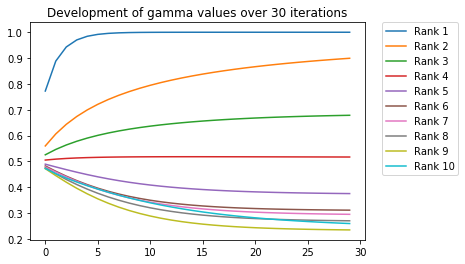

In [28]:
#print(got)
for i in range(10):
    plt.plot(range(iterations), got[i], label="Rank {}".format(i+1))
plt.title("Development of gamma values over {} iterations".format(iterations))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

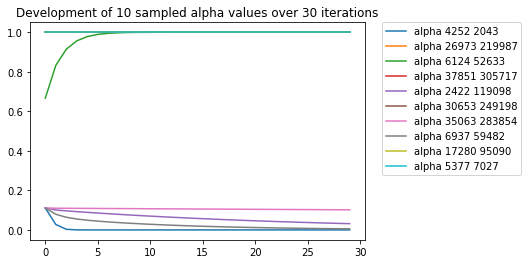

In [29]:
for alpha, values in aot.items():
    plt.plot(range(iterations), values, label="alpha {} {}".format(*alpha))

plt.title("Development of {} sampled alpha values over {} iterations".format(len(aot), iterations))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Step 6: Simulate Interleaving Experiment (10 points)
Having implemented the click models, it is time to run the simulated experiment.

For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion p of wins for E.
(Note 7: Some of the models above include an attractiveness parameter 𝑎uq. Use the relevance label to assign this parameter by setting 𝑎uq for a document u in the ranked list accordingly. 

In [ ]:
# TODO: Stian

### Step 7: Results and Analysis (30 points)
Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.


In [ ]:
# Step 7 code and markdown
# TODO: we should probably all contribute to this part